In [1]:
#importing needed modules
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#connecting to databse
conn = sqlite3.connect("factbook.db")
#sql query
query_1 = "SELECT * FROM sqlite_master WHERE type='table';"
#returning information in a form of pandas dataframe
pd.read_sql_query(query_1, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


There are only two tables in the database. Let's focus on the "facts" table for our analysis.

In [2]:
#running another query that returns the first 5 rows of the facts table in db
query_2 = "SELECT * FROM facts LIMIT 5;"
pd.read_sql_query(query_2, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


In [3]:
#minimum population, maximum population, minimum population growth, maximum population growth
query_3 = "SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth) FROM facts"
pd.read_sql_query(query_3, conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


A few things stand out in the previous output. There is a country with a population of 0 and another one with a population that is equal to the Earth's entire population. These countries are outliers within the table, so we'll check out which countries these are before we move on.

In [4]:
#countries with minimum population
query_min = "SELECT name FROM facts WHERE population = (SELECT MIN(population) FROM facts);"
pd.read_sql_query(query_min, conn)

,name
0,Antarctica


In [5]:
#countries with maximum population
query_max = "SELECT name FROM facts WHERE population = (SELECT MAX(population) FROM facts);"
pd.read_sql_query(query_max, conn)

,name
0,World


Rows for Antarctica and World are outliers in this dataset. Therefore, they will be excluded from further analysis from here on.

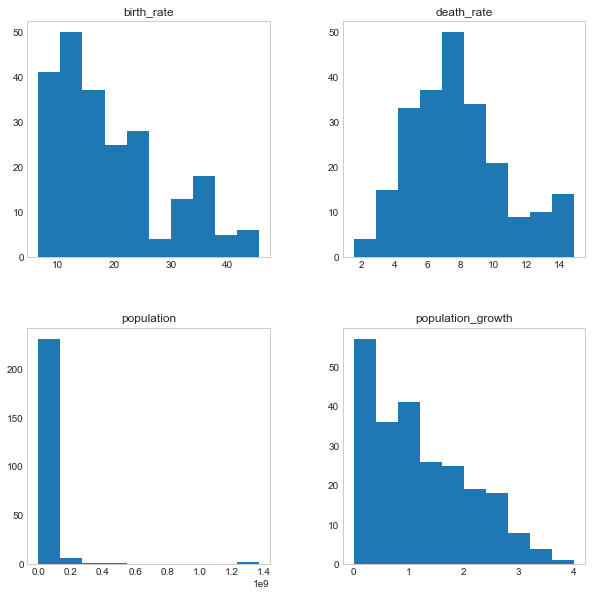

In [6]:
%matplotlib inline

sns.set_style('whitegrid')

#histogram for population, population growth, birth rate and death rate
query_hist = '''SELECT population, population_growth, birth_rate,
death_rate FROM facts WHERE population < 
(SELECT MAX(population) FROM facts) and population > 
(SELECT MIN(population) FROM facts);'''
a = pd.read_sql_query(query_hist, conn).hist(figsize=(10,10), grid=False)

We can make some interesting observations from these bar graphs. Birth rate is generally skewed to the right, meaning that there are more countries with relatively lower birth rates. Population growth has a similar pattern, where most of the countries have population growth rates that are on the lower side. Death rate is more evenly distributed than birth rate and population growth, averaging at about 8 per 1,000. There seems to be an outlier in the population histogram. We'll try to identify this country in the next step.

In [7]:
#query for population outlier
query_pop = '''SELECT name, population FROM facts WHERE population < (SELECT MAX(population) FROM facts)
ORDER BY population desc LIMIT 5'''
pd.read_sql_query(query_pop, conn)

,name,population
0,China,1367485388
1,India,1251695584
2,European Union,513949445
3,United States,321368864
4,Indonesia,255993674


As expected, the outliers were China and India. In the next section, we will explore which countries have the highest and lowest population density.

            name  pop_density
0          Macau        21168
1         Monaco        15267
2      Singapore         8259
3      Hong Kong         6655
4     Gaza Strip         5191
5      Gibraltar         4876
6        Bahrain         1771
7       Maldives         1319
8          Malta         1310
9        Bermuda         1299
10    Bangladesh         1297
11  Sint Maarten         1167
12      Guernsey          847
13        Jersey          838
14        Taiwan          725
15      Barbados          675
16     Mauritius          660
17         Aruba          623
18       Lebanon          604
19  Saint Martin          588


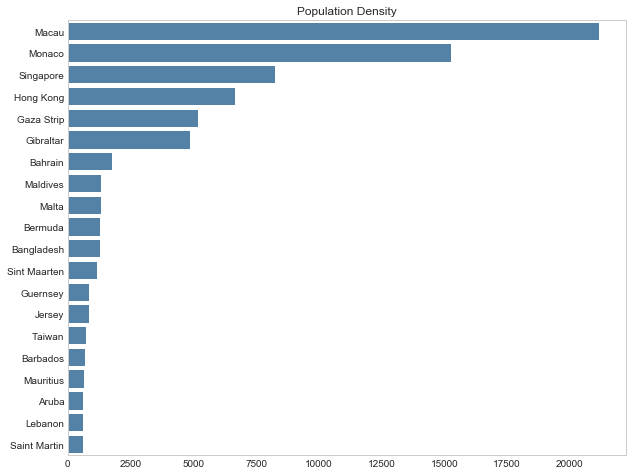

In [9]:
#query for high population density
query_high_pd = '''SELECT name, 
population / area_land pop_density
FROM facts ORDER BY pop_density desc LIMIT 20'''
pop_density_20 = pd.read_sql_query(query_high_pd, conn)

plt.figure(figsize=(10,8))
ax = sns.barplot(x='pop_density', y='name', data=pop_density_20, color='steelblue')
ax.set(ylabel='', xlabel='', title='Population Density')
ax.grid(False)
print(pop_density_20)

Now we will create a historgram to see the distribution of population density.

[Text(0.5,1,'Population Density Distribution')]

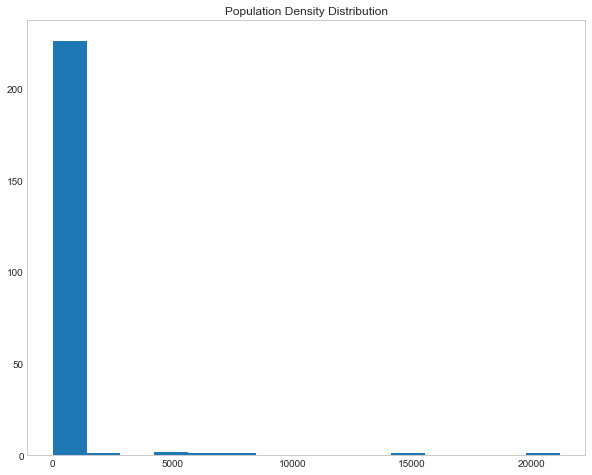

In [11]:
#histogram of population density
query_high_pd_hist = '''SELECT name, 
population / area_land pop_density
FROM facts'''
fig, ax = plt.subplots(figsize=(10,8))
pop_density = pd.read_sql_query(query_high_pd_hist, conn).hist(bins=15, grid=False, ax=ax)
ax.set(title='Population Density Distribution')

This histogram has a similar pattern as the population histogram that was seen earlier in this notebook. Now we'll take a look at columns with float data types and see if any obvious relationships standout between columns.

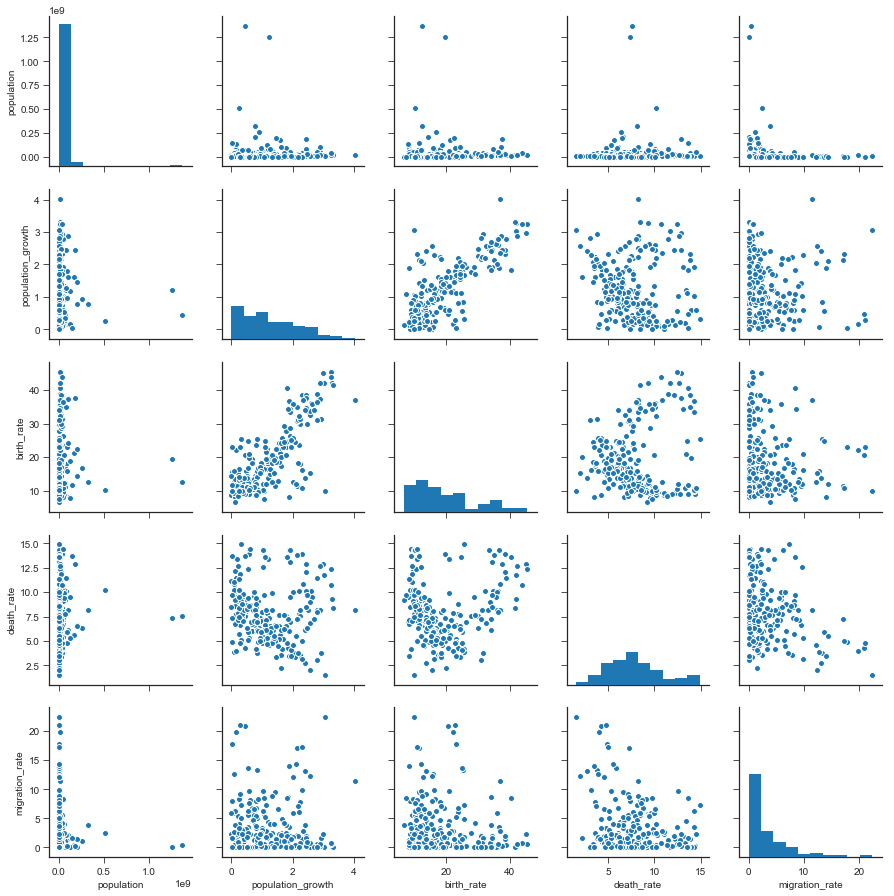

In [12]:
df_query = 'SELECT * from facts'
df = pd.read_sql_query(df_query, conn)
sns.set_style('ticks')
sns.pairplot(df[['population', 'population_growth', 'birth_rate', 'death_rate',
       'migration_rate']].dropna())

Observations made from this chart are:

1) There is an obvious relationship between population growth and birth rate. Otherwise, no clear relationships stand out from these charts.

2) Population growth and birth rate have a similar distribution pattern.